<a href="https://colab.research.google.com/github/nspeer12/AI_CAP4630/blob/master/hw4/hw4.3.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning Xception

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the Xception model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers.

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-20 05:58:35--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 2404:6800:4008:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   134MB/s    in 0.5s    

2020-04-20 05:58:36 (134 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Xception Model
Xception is convolutional neural network model developed by François Chollet. It is based on the already performant Inception model. Xception performs a number depthwise separable convolutions [1]. With a 94.5% accuracy on ImageNet classifications, Xception slightly, but significantly outperforms its predecessor, Inception-v3 at 94.1% accuracy [2]. 

### Depthwise Convolutions

Depthwise in the realm of images and computer vision would be equivalent to the RGB channels of an image. Depthwise convolutions involve a kernel for each separate channel of the input. The resulting output has the same depth as the input.

### Seperable Convolutions

Separable convolutions are an operation in which not one, but two or more kernels are applied to an input matrix. Each separable convolution produces an intermediate matrix that is able to be convoluted by the next kernel. 


Source: [1]


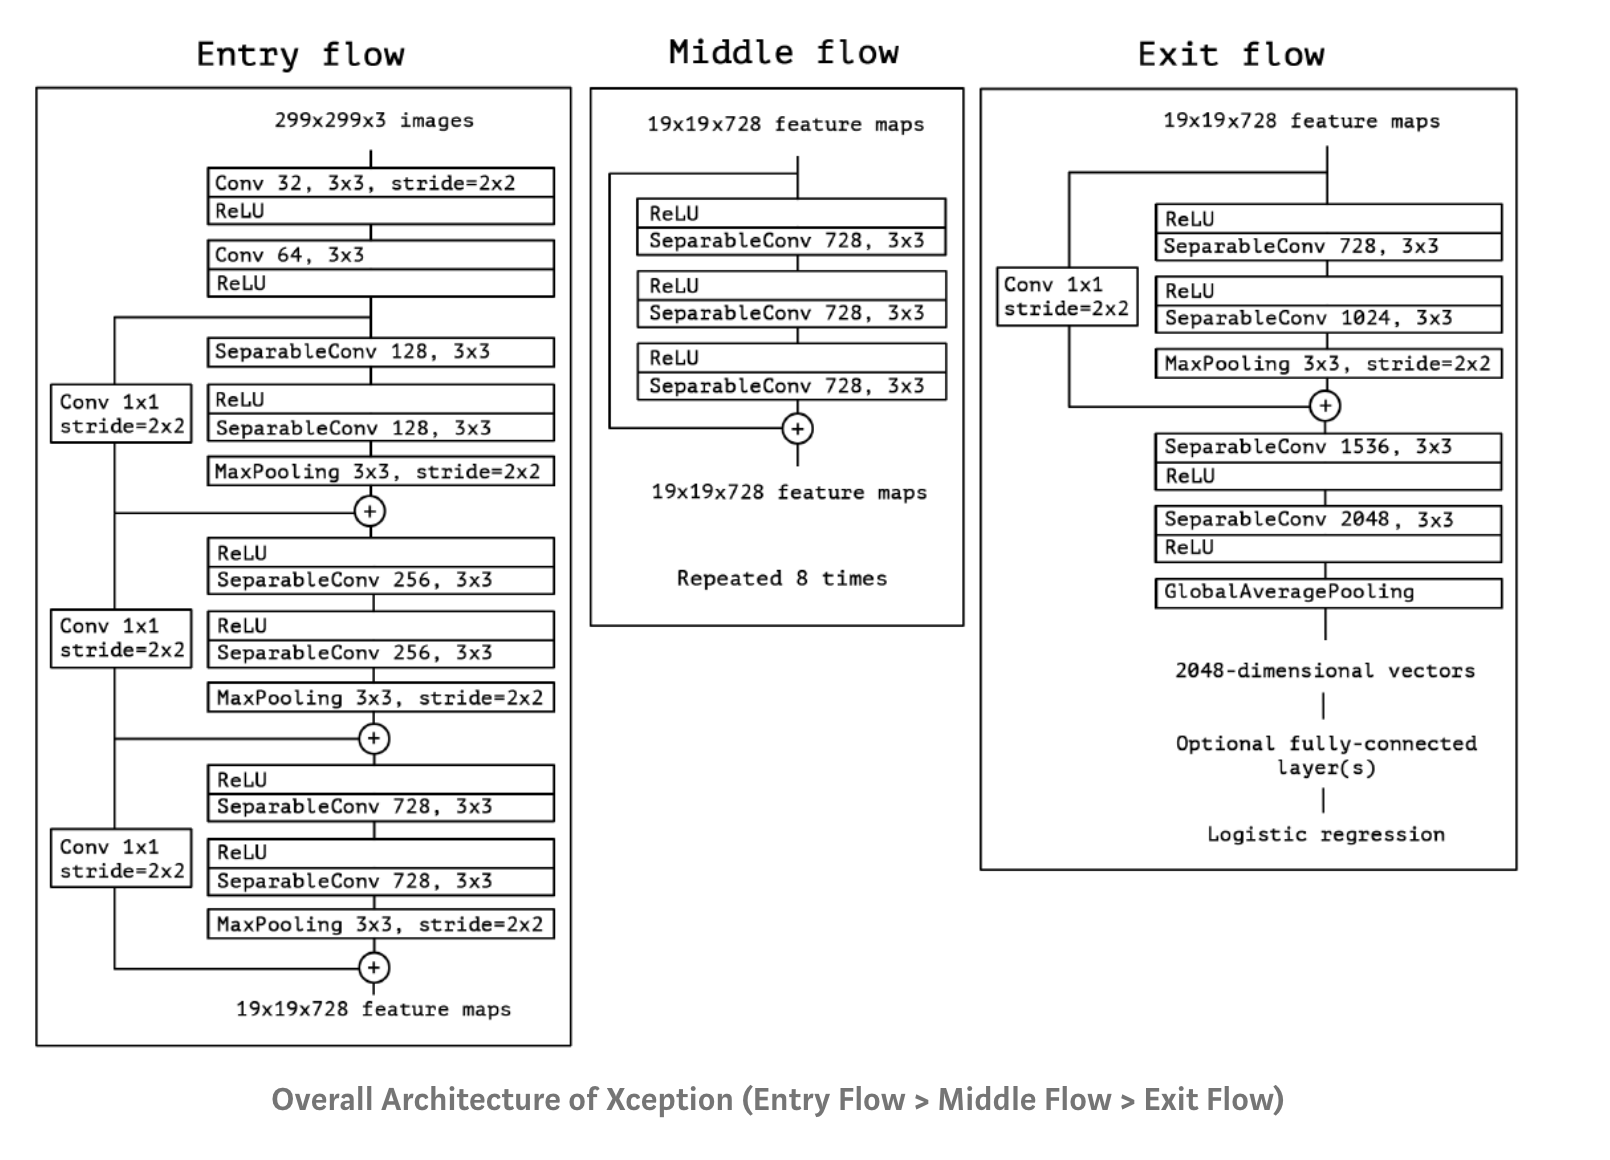

## Build network with Xception convolution base and custom densely connected layers

### Load the convolutional base

In [4]:
from keras.applications import Xception

conv_base = Xception(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Using TensorFlow backend.


### Freeze the convolutional base

In [0]:
conv_base.trainable = False

# Dense Layers Hypothesis

In order to take the Xception model and adapt it to the problem of classifying cats and dogs, methodically chosing dense layers and output layers is an important step. In essence, the 2048 dimensional output vector and funnel it down to a single output node that operates as a logistic regression. How many nodes and layers are necessary to achieve results with accuracy above 95% with a reasonable training time, memory and time complexity? 


### Hidden Layer Dimensions

Xception outputs a 2048 dimensional vector which is conveintly $2^{11}$. For the size of my dense layers, I will strictly choose layers of size $2^n$. While playing around with different shapes and sizes, I found that two or three hidden layers yeilded decent result above 90%. Four hidden layers was too slow to train and didn't net any noticable results. In this second experiment I will be using three layers of sizes 1024, 256 and 32, and an output layer of size 1 with a sigmoid activation.

### Dropout Layer

Between the 1024 layer and 256 layer, I added a dropout layer. This dropout layer will randomly ignore 5% of the nodes in the 1024 layer while making predicitons. There are a few reasons, primarily to prevent overfitting to training data. By adding the dropout layer, I will compensate by training the model for an increased number of epochs so the model can still fit nicely to the training examples.

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)

# flatten output of convolutional model and add a fully connected layer
model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
#model.add(layers.Dense(32, activation='relu'))

# logistic regression layer
model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 47,076,905
Trainable params: 26,215,425
Non-trainable params: 20,861,480
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 21s 210ms/step - loss: 0.4602 - acc: 0.7700 - val_loss: 0.0296 - val_acc: 0.9270
Epoch 2/30
100/100 [==============================] - 17s 169ms/step - loss: 0.3896 - acc: 0.8080 - val_loss: 0.0687 - val_acc: 0.9630
Epoch 3/30
100/100 [==============================] - 17s 170ms/step - loss: 0.3574 - acc: 0.8405 - val_loss: 0.1468 - val_acc: 0.9550
Epoch 4/30
100/100 [==============================] - 17s 169ms/step - loss: 0.3319 - acc: 0.8470 - val_loss: 0.3325 - val_acc: 0.9690
Epoch 5/30
100/100 [==============================] - 17s 168ms/step - loss: 0.3309 - acc: 0.8545 - val_loss: 0.0541 - val_acc: 0.9690
Epoch 6/30
100/100 [==============================] - 17s 169ms/step - loss: 0.3222 - acc: 0.8565 - val_loss: 3.6982e-05 - val_acc: 0.9740
Epoch 7/30
100/100 [==============================] - 17s 169ms/step - loss: 0.2966 - acc: 0.8675 - va

## Display curves of loss and accuracy during training

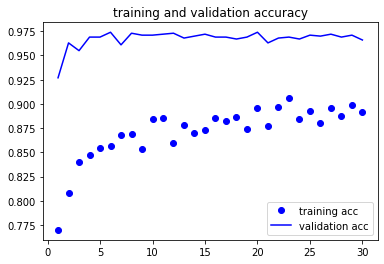

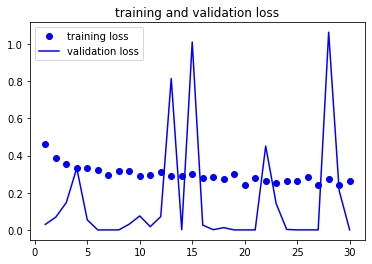

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

Set all layers in the convolutional base to trainable

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

# Compilation and Training

### Compilation

I am going with Adam as an optimizer with a learning rate of 0.00001. The learning rate is quite small, the reason being so we don't undo all of the transfered learning the Xception model has. We only want to fine tune this to our classification problem.


### Training

Since I added a 20% dropout layer, I increased the number of epochs to 150. I found this to be reasonable number of epochs, and going beyond gave me diminishing returns and overfitting.

In [0]:
# compile model

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(lr=0.00001), 
    metrics=['acc'])

# train
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=150,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/150
100/100 [==============================] - 20s 202ms/step - loss: 0.2555 - acc: 0.8940 - val_loss: 0.0794 - val_acc: 0.9380
Epoch 2/150
100/100 [==============================] - 17s 170ms/step - loss: 0.2531 - acc: 0.9005 - val_loss: 0.1029 - val_acc: 0.9420
Epoch 3/150
100/100 [==============================] - 17s 169ms/step - loss: 0.2332 - acc: 0.9090 - val_loss: 0.2054 - val_acc: 0.9360
Epoch 4/150
100/100 [==============================] - 17s 170ms/step - loss: 0.2254 - acc: 0.9025 - val_loss: 0.0406 - val_acc: 0.9350
Epoch 5/150
100/100 [==============================] - 17s 171ms/step - loss: 0.2571 - acc: 0.8925 - val_loss: 0.1374 - val_acc: 0.9350
Epoch 6/150
100/100 [==============================] - 17s 172ms/step - loss: 0.2251 - acc: 0.9110 - val_loss: 0.4447 - val_acc: 0.9420
Epoch 7/150
100/100 [==============================] - 17s 171ms/step - loss: 0.2262 - acc: 0.9135 - val_loss: 0.2312 - val_acc: 0.9300
Epoch 8/150
100/100 [===========================

## Display learning curves during fine-tuning

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [0]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

# Save the model

Unfortunately the code provided in the notebook for saving the model is not working. 

In [0]:
model_fname = 'xception_512_62.h5' 
model.save(model_fname)



In [0]:
from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)

# Sources

[1] *Xception: Deep Learning with Depthwise Separable Convolutions* by François Chollethttps://arxiv.org/abs/1610.02357

[2] *A Basic Introduction to Seprable Convolutions* by Chi-Feng Wang https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728

[3] *Review: Xception* by Sik-Ho Tsang https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568